# Variational Autoencoders: From Probability Theory to Practice

## 1. Probabilistic Foundations
Let $(\Omega, \sigma, \mathbb{P})$ be a probability space. Our data points $\{x_i\}_{i=1}^n$ are realizations of random variables $X_i: \Omega \to \mathbb{R}^d$. The push-forward measure $P_X = \mathbb{P} \circ X^{-1}$ defines the distribution of our data.
We aim to learn this distribution through a latent variable model. For each observation $x_i$, we posit the existence of an unobserved latent variable $z_i$ which is a realization of a random variable $Z_i: \Omega \to \mathbb{R}^k$, with push-forward measure $P_Z = \mathbb{P} \circ Z^{-1}$ and density $p_Z$ with respect to Lebesgue measure (which exists by Radon-Nikodym since we assume $P_Z \ll \lambda$ where $\lambda$ is Lebesgue measure).

## 2. The Model Class
Let $p_X$ be the true (unknown) density of $P_X$ with respect to Lebesgue measure (which exists by Radon-Nikodym since we assume $P_X \ll \lambda$ where $\lambda$ is Lebesgue measure).
We aim to approximate $p_X$ using a latent variable model. Specifically, we consider a family of joint densities $p_{X,Z}(\cdot, \cdot; \theta)$ parameterized by $\theta$, which induce marginal densities:
$$p_\theta(x_i) = \int_{\mathbb{R}^k} p_{X,Z}(x_i, z; \theta) dz$$
The maximum likelihood objective is then:
$$\hat{\theta} = \argmax_{\theta} \sum_{i=1}^n \log p_\theta(x_i)$$

## 3. The Evidence Lower Bound (ELBO)
The integral in our objective is typically intractable. We can derive a lower bound through Jensen's inequality. For any probability density $q$:
$$\log p(x_i) = \log \int_{\mathbb{R}^k} p(x_i, z) dz = \log \int_{\mathbb{R}^k} q(z) \frac{p(x_i, z)}{q(z)} dz$$
By Jensen's inequality and the concavity of log:
$$\log \mathbb{E}_{Z \sim q}\left[\frac{p(x_i, Z)}{q(Z)}\right] \geq \mathbb{E}_{Z \sim q}\left[\log \frac{p(x_i, Z)}{q(Z)}\right]$$
This gives us our evidence lower bound (ELBO):
$$\log p(x_i) \geq \int_{\mathbb{R}^k} q(z) \log \frac{p(x_i, z)}{q(z)} dz$$

## 4. Factorization and Amortization
We can decompose the joint density using the chain rule: $p(x_i, z) = p(x_i|z)p(z)$. This allows us to rewrite the ELBO:
$$\mathbb{E}_{Z \sim q}[\log p(x_i|Z)] - D_\text{KL}(q|p_Z)$$
where $p_Z$ is our prior density on the latent space.
This form is computationally tractable because:

The first term can be estimated with Monte Carlo sampling:
$$\mathbb{E}_{Z \sim q}[\log p(x_i|Z)] \approx \frac{1}{S}\sum_{s=1}^S \log p(x_i|z^{(s)})$$
where $z^{(s)} \sim q(z; g_\phi(x_i))$. Often we just sample once, so the reconstruction loss per data point is just $\log p(x_i|z)$. The KL divergence term has a closed form when using normal distributions.

This is much more tractable than the original objective:
$\log \int p(x_i|z)p(z)dz$
which would require integrating over all $z$ just to evaluate once.
For additional computational efficiency, we make two key assumptions:

$\textbf{Mean-Field Assumption}$: The joint distribution of latent variables factors across data points:
$$q(z_1, ..., z_n) = \prod_{i=1}^n q_i(z_i)$$
$\textbf{Amortized Inference}$: Instead of learning separate variational distributions for each data point, we learn a mapping $g_\phi: \mathbb{R}^d \to \mathcal{P}(\mathbb{R}^k)$ where $\mathcal{P}(\mathbb{R}^k)$ represents the space of probability measures on $\mathbb{R}^k$:
$$q_i(z_i) = q(z_i; g_\phi(x_i))$$

## 5. Parameterization and Computation
We typically choose:

Prior: $p(z) = \mathcal{N}(0, I)$

Variational family: $q(z; g_\phi(x)) = \mathcal{N}(\mu_\phi(x), \text{diag}(\sigma^2_\phi(x)))$

Likelihood: $p(x|z) = f_\theta(z)$ for some neural network $f_\theta$

This gives us the final optimization objective:
$$\max_{\theta, \phi} \sum_{i=1}^n \left[\mathbb{E}_{z \sim q(z; g\phi(x_i))} \log p(x_i|z; f_\theta) - D_\text{KL}(q(z; g_\phi(x_i))|p(z))\right]$$
The KL divergence term has a closed form for normal distributions. The expectation term requires Monte Carlo estimation, which is made differentiable through the reparameterization trick:
Instead of sampling directly from $q(z; g_\phi(x_i))$, we sample:
$$\epsilon \sim \mathcal{N}(0, I)$$
$$z = \mu_\phi(x_i) + \sigma_\phi(x_i) \odot \epsilon$$
This makes the sampling process differentiable with respect to the parameters $\phi$.

## Notes:
This is the standard VI setup with local latent variables, not a fully Bayesian treatment with global latents

In [7]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import numpy as np
import optax
from sklearn.datasets import fetch_openml

def get_mnist():
    """Load and normalize MNIST using scikit-learn."""
    print("Loading MNIST...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = X.astype('float32') / 255.
    return X, y

def get_batch(X, batch_size, key):
    """Get a random batch from data."""
    idx = random.randint(key, (batch_size,), 0, len(X))
    return X[idx]

def init_network_params(key, input_dim, hidden_dim, latent_dim):
    """Initialize neural network parameters."""
    # Encoder: input_dim -> hidden_dim -> latent_dim*2 (mean and logvar)
    key1, key2, key3, key4 = random.split(key, 4)
    
    encoder_params = {
        'h1': {
            'w': random.normal(key1, (input_dim, hidden_dim)) / jnp.sqrt(input_dim),
            'b': jnp.zeros(hidden_dim)
        },
        'h2': {
            'w': random.normal(key2, (hidden_dim, latent_dim * 2)) / jnp.sqrt(hidden_dim),
            'b': jnp.zeros(latent_dim * 2)
        }
    }
    
    # Decoder: latent_dim -> hidden_dim -> input_dim
    decoder_params = {
        'h1': {
            'w': random.normal(key3, (latent_dim, hidden_dim)) / jnp.sqrt(latent_dim),
            'b': jnp.zeros(hidden_dim)
        },
        'h2': {
            'w': random.normal(key4, (hidden_dim, input_dim)) / jnp.sqrt(hidden_dim),
            'b': jnp.zeros(input_dim)
        }
    }
    
    return {'encoder': encoder_params, 'decoder': decoder_params}

def encoder(params, x):
    """Encoder network mapping x to mean and logvar of q(z|x)."""
    h = jnp.tanh(x @ params['h1']['w'] + params['h1']['b'])
    h = h @ params['h2']['w'] + params['h2']['b']
    mean, logvar = jnp.split(h, 2, axis=-1)
    return mean, logvar

def reparameterize(key, mean, logvar):
    """Reparameterization trick: z = mean + std * epsilon."""
    eps = random.normal(key, mean.shape)
    return mean + jnp.exp(0.5 * logvar) * eps

def decoder(params, z):
    """Decoder network mapping z to reconstruction."""
    h = jnp.tanh(z @ params['h1']['w'] + params['h1']['b'])
    x_recon = jax.nn.sigmoid(h @ params['h2']['w'] + params['h2']['b'])
    return x_recon

def vae_loss(params, key, batch):
    """Compute ELBO loss for a batch."""
    mean, logvar = encoder(params['encoder'], batch)
    z = reparameterize(key, mean, logvar)
    x_recon = decoder(params['decoder'], z) # p(x|z)
    
    # Reconstruction loss (binary cross entropy)
    recon_loss = -jnp.sum(
        batch * jnp.log(x_recon + 1e-8) + 
        (1 - batch) * jnp.log(1 - x_recon + 1e-8)
    ) # equals reconstruction loss because of binary inputs, so E_q[log p(x|z)] = BCE
    
    # KL divergence
    kl_loss = -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
    
    return recon_loss + kl_loss

@jit
def train_step(params, opt_state, key, batch):
    """Single training step."""
    loss_val, grads = jax.value_and_grad(vae_loss)(params, key, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val

# Training setup and main loop
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 32
    input_dim = 784  # flattened MNIST
    hidden_dim = 512
    latent_dim = 2
    learning_rate = 1e-3
    num_epochs = 50

    # Initialize parameters and optimizer
    key = random.PRNGKey(0)
    params = init_network_params(key, input_dim, hidden_dim, latent_dim)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    # Load data
    X, _ = get_mnist()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = len(X) // batch_size
        
        for i in range(num_batches):
            key, subkey = random.split(key)
            batch = get_batch(X, batch_size, subkey)
            params, opt_state, loss = train_step(params, opt_state, subkey, batch)
            total_loss += loss
        
        avg_loss = total_loss / num_batches
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Average Loss: {avg_loss}")

Loading MNIST...


2024-12-31 20:09:17.758636: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1061] Compiling 134 configs for 7 fusions on a single thread.


Epoch 0, Average Loss: 5729.38330078125
Epoch 10, Average Loss: 4796.84326171875
Epoch 20, Average Loss: 4685.5810546875
Epoch 30, Average Loss: 4633.04150390625
Epoch 40, Average Loss: 4595.45849609375


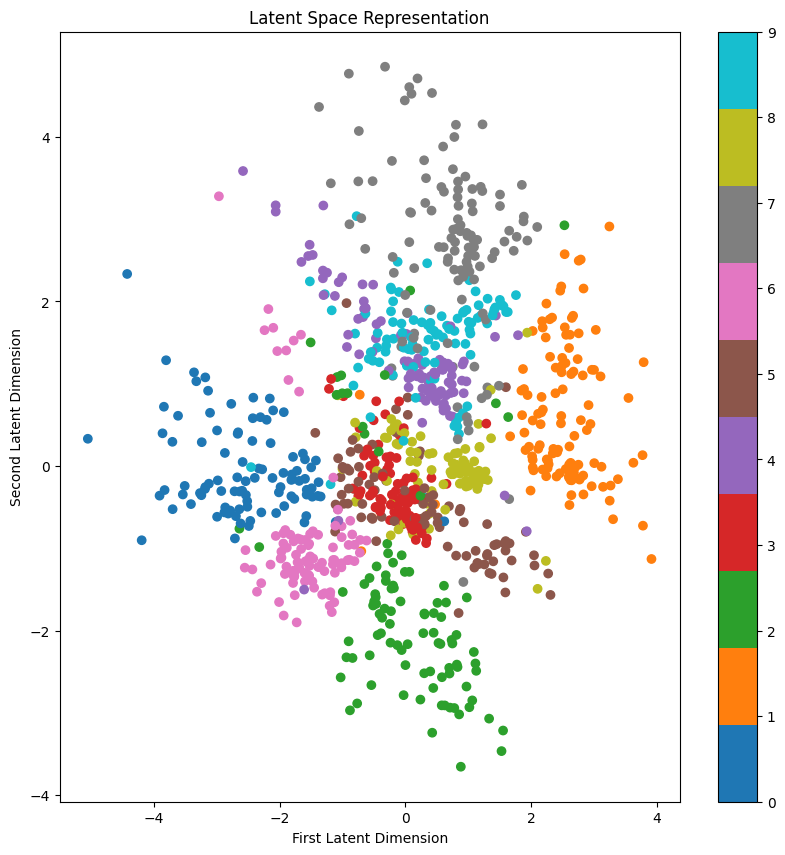

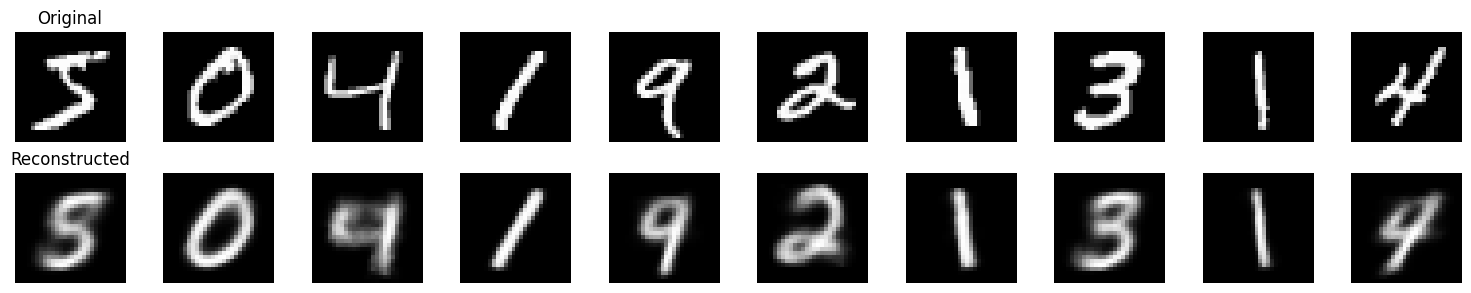

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load test data and labels
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32') / 255.
test_images = X[:1000]  # Take first 1000 for visualization
test_labels = y[:1000]

# Get latent representations
def get_latent_reps(params, images):
    mean, _ = encoder(params['encoder'], images)
    return mean  # Just use mean, no sampling needed for visualization

latent_reps = get_latent_reps(params, test_images)

# Scatter plot of latent space
plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], 
                     c=test_labels.astype(int), cmap='tab10')
plt.colorbar(scatter)
plt.title('Latent Space Representation')
plt.xlabel('First Latent Dimension')
plt.ylabel('Second Latent Dimension')
plt.show()

# Let's show some reconstructions
n_examples = 10
test_subset = test_images[:n_examples]

# Get reconstructions
mean, _ = encoder(params['encoder'], test_subset)
reconstructed = decoder(params['decoder'], mean)

# Plot original vs reconstructed
plt.figure(figsize=(15, 3))
for i in range(n_examples):
    # Original
    plt.subplot(2, n_examples, i + 1)
    plt.imshow(test_subset[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')
    
    # Reconstructed
    plt.subplot(2, n_examples, n_examples + i + 1)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')
plt.tight_layout()
plt.show()

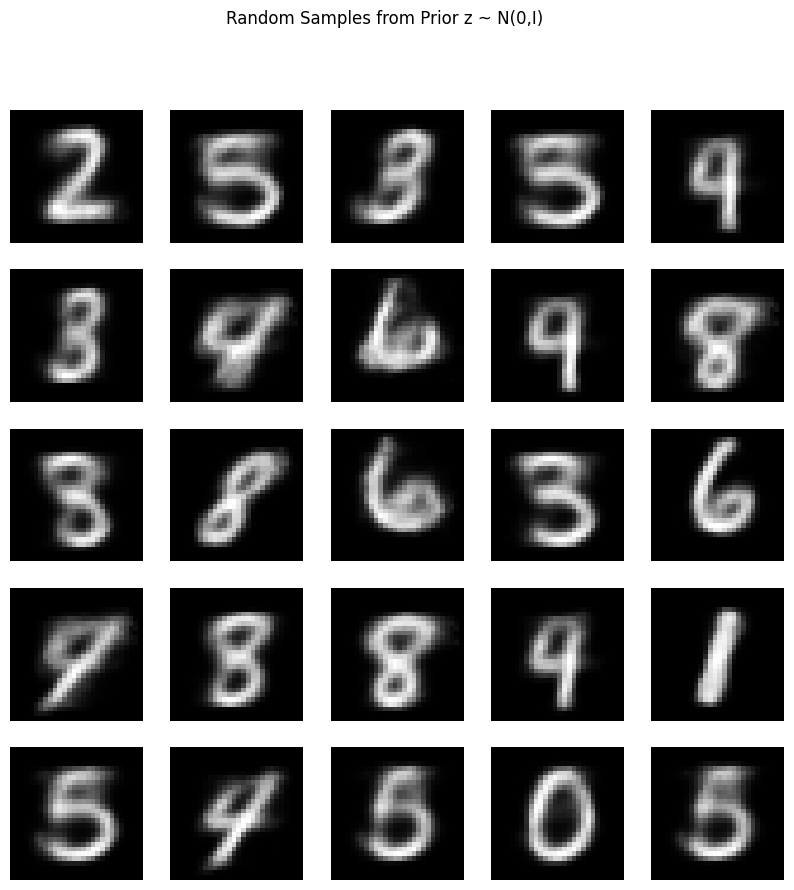

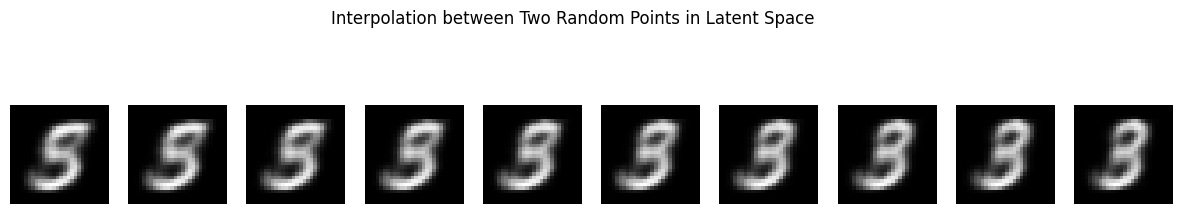

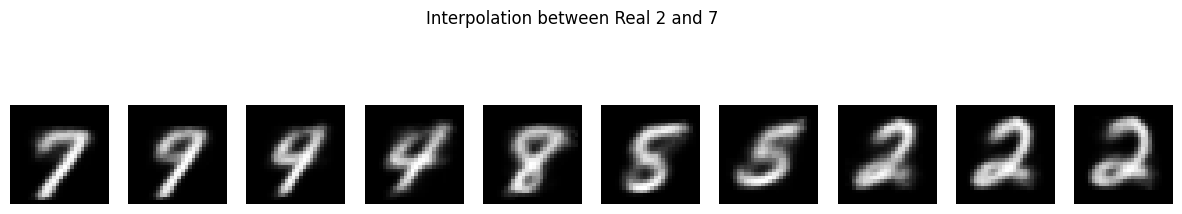

In [10]:
import matplotlib.pyplot as plt

# Generate random samples
key = random.PRNGKey(0)
n_samples = 25  # 5x5 grid
z = random.normal(key, (n_samples, latent_dim))
samples = decoder(params['decoder'], z)

# Plot random samples
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Random Samples from Prior z ~ N(0,I)')
plt.show()

# Interpolation between two random points
key, subkey = random.split(key)
z1 = random.normal(key, (1, latent_dim))
z2 = random.normal(subkey, (1, latent_dim))
n_interp = 10
alphas = jnp.linspace(0, 1, n_interp)
z_interp = jnp.vstack([a * z1 + (1-a) * z2 for a in alphas])
interp_samples = decoder(params['decoder'], z_interp)

# Plot interpolation
plt.figure(figsize=(15, 3))
for i in range(n_interp):
    plt.subplot(1, n_interp, i + 1)
    plt.imshow(interp_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Interpolation between Two Random Points in Latent Space')
plt.show()

# Let's also try interpolating between two specific digits
# First find embeddings of real digits
test_images = X[:1000]
test_labels = y[:1000].astype(int)

# Get indices of a 2 and a 7 (for example)
idx_2 = jnp.where(test_labels == 2)[0][0]
idx_7 = jnp.where(test_labels == 7)[0][0]

# Get their latent representations
mean_2, _ = encoder(params['encoder'], test_images[idx_2:idx_2+1])
mean_7, _ = encoder(params['encoder'], test_images[idx_7:idx_7+1])

# Interpolate between them
z_interp_digits = jnp.vstack([a * mean_2 + (1-a) * mean_7 for a in alphas])
interp_digits = decoder(params['decoder'], z_interp_digits)

# Plot original digits and interpolation
plt.figure(figsize=(15, 3))
for i in range(n_interp):
    plt.subplot(1, n_interp, i + 1)
    plt.imshow(interp_digits[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Interpolation between Real 2 and 7')
plt.show()

# $\beta$-VAE

Recall that we generally use a spherical Gaussian prior. This means that each latent dimension is independent of the others. To enforce this in our posteriors, we can add a constraint on the divergence term, which (under conditions) is equivalent to adding a penalty $\beta > 1$ to scale the divergence term.

In [18]:
def beta_vae_loss(params, key, batch, beta):
    mean, logvar = encoder(params['encoder'], batch)
    z = reparameterize(key, mean, logvar)
    x_recon = decoder(params['decoder'], z)
    
    # Reconstruction loss (unchanged)
    recon_loss = -jnp.sum(
        batch * jnp.log(x_recon + 1e-8) + 
        (1 - batch) * jnp.log(1 - x_recon + 1e-8)
    )
    
    # KL divergence now weighted by beta
    kl_loss = -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))
    
    return recon_loss + beta * kl_loss

@jit
def beta_train_step(params, opt_state, key, batch, beta):
    """Single training step."""
    loss_val, grads = jax.value_and_grad(beta_vae_loss)(params, key, batch, beta)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_val

# repeat training loop with beta_vae_loss and beta_train_step
# Hyperparameters
batch_size = 32
input_dim = 784  # flattened MNIST
hidden_dim = 512
latent_dim = 2
learning_rate = 1e-3
num_epochs = 50
beta = 5 

# Initialize parameters and optimizer
key = random.PRNGKey(0)
params = init_network_params(key, input_dim, hidden_dim, latent_dim)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = len(X) // batch_size
    
    for i in range(num_batches):
        key, subkey = random.split(key)
        batch = get_batch(X, batch_size, subkey)
        params, opt_state, loss = beta_train_step(params, opt_state, subkey, batch, beta)
        total_loss += loss
    
    avg_loss = total_loss / num_batches
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Average Loss: {avg_loss}")

Epoch 0, Average Loss: 6280.8759765625
Epoch 10, Average Loss: 5467.77783203125
Epoch 20, Average Loss: 5396.3642578125
Epoch 30, Average Loss: 5367.08837890625
Epoch 40, Average Loss: 5337.46728515625


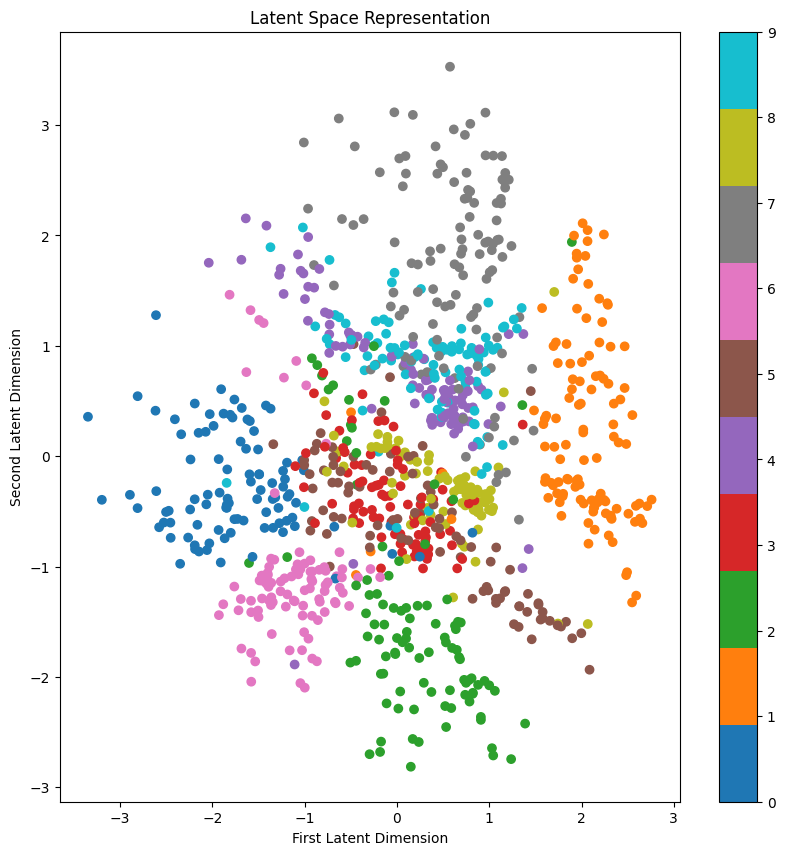

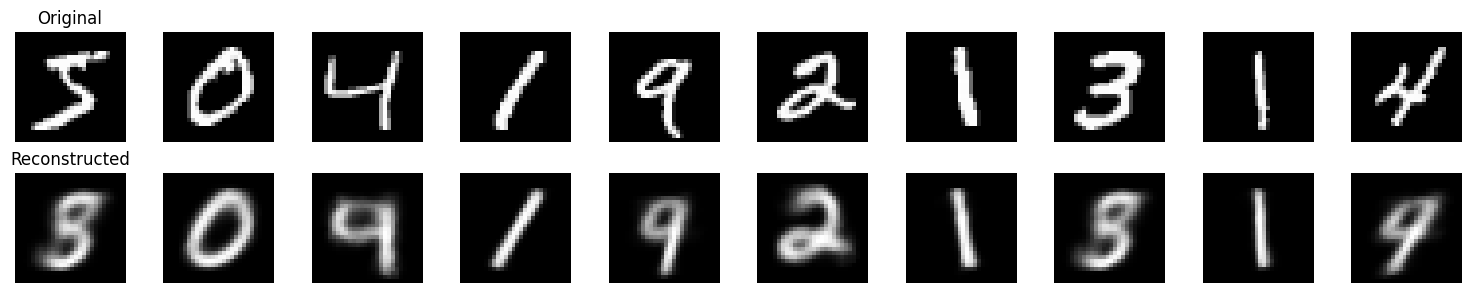

In [19]:
# repeat visualization and sampling code
# Scatter plot of latent space
latent_reps = get_latent_reps(params, test_images)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_reps[:, 0], latent_reps[:, 1], 
                     c=test_labels.astype(int), cmap='tab10')
plt.colorbar(scatter)
plt.title('Latent Space Representation')
plt.xlabel('First Latent Dimension')
plt.ylabel('Second Latent Dimension')
plt.show()

# Let's show some reconstructions
n_examples = 10
test_subset = test_images[:n_examples]

# Get reconstructions
mean, _ = encoder(params['encoder'], test_subset)
reconstructed = decoder(params['decoder'], mean)

# Plot original vs reconstructed
plt.figure(figsize=(15, 3))
for i in range(n_examples):
    # Original
    plt.subplot(2, n_examples, i + 1)
    plt.imshow(test_subset[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')
    
    # Reconstructed
    plt.subplot(2, n_examples, n_examples + i + 1)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')
plt.tight_layout()
plt.show()

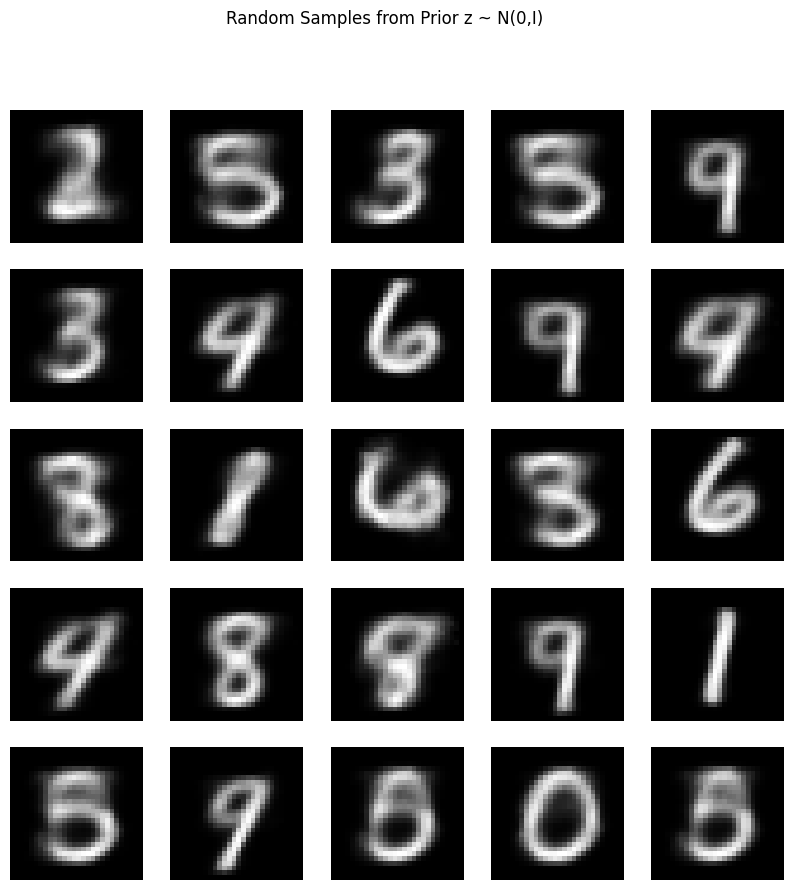

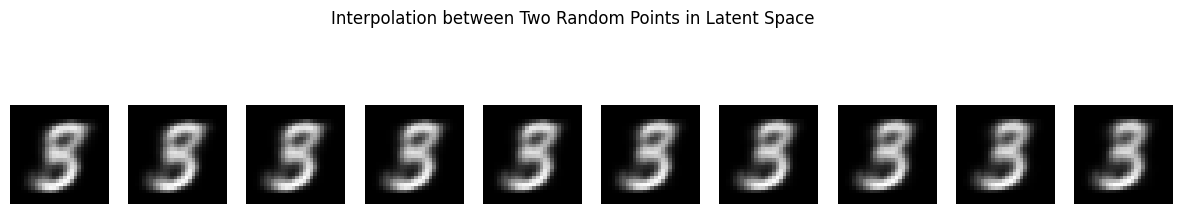

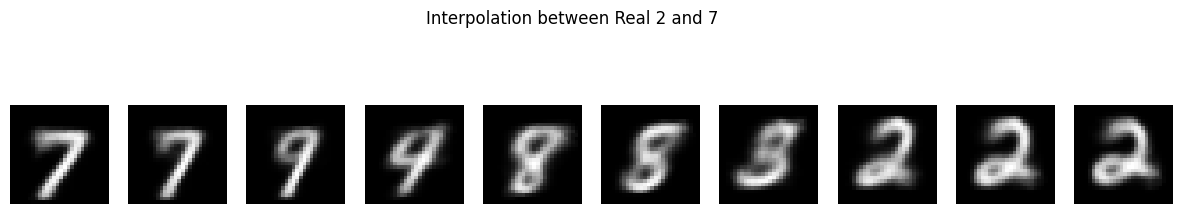

In [20]:
# Generate random samples
key = random.PRNGKey(0)
n_samples = 25  # 5x5 grid
z = random.normal(key, (n_samples, latent_dim))
samples = decoder(params['decoder'], z)

# Plot random samples
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Random Samples from Prior z ~ N(0,I)')
plt.show()

# Interpolation between two random points
key, subkey = random.split(key)
z1 = random.normal(key, (1, latent_dim))
z2 = random.normal(subkey, (1, latent_dim))
n_interp = 10

alphas = jnp.linspace(0, 1, n_interp)
z_interp = jnp.vstack([a * z1 + (1-a) * z2 for a in alphas])
interp_samples = decoder(params['decoder'], z_interp)

# Plot interpolation
plt.figure(figsize=(15, 3))
for i in range(n_interp):
    plt.subplot(1, n_interp, i + 1)
    plt.imshow(interp_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Interpolation between Two Random Points in Latent Space')
plt.show()

# Let's also try interpolating between two specific digits
# First find embeddings of real digits
test_images = X[:1000]
test_labels = y[:1000].astype(int)

# Get indices of a 2 and a 7 (for example)
idx_2 = jnp.where(test_labels == 2)[0][0]
idx_7 = jnp.where(test_labels == 7)[0][0]

# Get their latent representations
mean_2, _ = encoder(params['encoder'], test_images[idx_2:idx_2+1])
mean_7, _ = encoder(params['encoder'], test_images[idx_7:idx_7+1])

# Interpolate between them
z_interp_digits = jnp.vstack([a * mean_2 + (1-a) * mean_7 for a in alphas])
interp_digits = decoder(params['decoder'], z_interp_digits)

# Plot original digits and interpolation
plt.figure(figsize=(15, 3))
for i in range(n_interp):
    plt.subplot(1, n_interp, i + 1)
    plt.imshow(interp_digits[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle('Interpolation between Real 2 and 7')
plt.show()

# Causal Representation Learning

The motivation for the $\beta$-VAE (and related architectures such as FactorVAE) is to create disentangled representations. Informally, these are interpretable and sparse representations: ones that we can understand, and such that few of them shift. Contrast this with an entangled representation, where even a single real-world factor of variation changing may totally distort the representation, making it dissimilar to its previous version despite the representatum being essentially the same.

Drawing on the theory of causality, researchers have argued that interpretable and sparse representations are precisely nodes in causal graphs. Intuitively, this corresponds to how we humans represent the world, carving it up into distinct objects interacting with one another. Importantly, nodes in a causal graph are not necessarily independent! Thus, the penalties used in architectures like $\beta$-VAE are inappropriate. Instead, we can hope to achieve disentanglement using causal constraints.